In [ ]:
# https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
# https://zhuanlan.zhihu.com/p/34904202

In [5]:
import time
import numpy as np
import pandas as pd
import featuretools as ft
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

### Data Preparation

In [2]:
# LabelEncode
train = pd.read_csv("train.csv", index_col=None)
test = pd.read_csv("test.csv", index_col=None)

In [3]:
print(train.shape)
print(test.shape)

(28180, 235)
(10000, 234)


In [4]:
print(train.head())
print(train.columns)

        building_id  building_material  city     txn_dt  total_floor  \
0  e3mMIMR3JJqCaXz1                  8    21 1951-02-15            4   
1  LgwzgklNvy4QCtq5                  8     7 1951-06-21            5   
2  ucIR2NLLsC3T650L                  8     7 1952-10-22            4   
3  jre1pJhcQj91Kdky                  8    21 1955-10-23           24   
4  rQpYpY9nRG7X5mmr                  1    21 1956-07-21            2   

   building_type  building_use building_complete_dt  parking_way  \
0              3             2           1917-03-02            2   
1              1             2           1921-08-02            2   
2              1             2           1916-07-02            2   
3              0             2           1950-03-03            0   
4              4             2           1918-11-01            2   

   parking_area  ...  XIV_500  XIV_index_500  XIV_1000  XIV_index_1000  \
0           NaN  ...       58              1       157               1   
1         

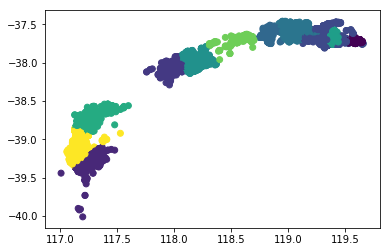

In [10]:
plt.scatter(train["lon"], train["lat"], c=train["city"])  # 經緯度可判斷蛋黃區

In [6]:
# lower cases
train.columns = [colname.lower() for colname in train.columns.values.tolist()]
test.columns = [colname.lower() for colname in test.columns.values.tolist()]

In [6]:
train.describe()

,building_material,city,total_floor,building_type,building_use,parking_way,parking_area,parking_price,txn_floor,land_area,...,xiv_500,xiv_index_500,xiv_1000,xiv_index_1000,xiv_5000,xiv_index_5000,xiv_10000,xiv_index_10000,xiv_min,total_price
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,3103.000000,1.393500e+04,44098.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000,60000.0,60000.000000,6.000000e+04
mean,7.267917,11.414533,7.638250,1.931817,2.319200,1.585700,7.211837,5.025058e+04,5.389269,28.194011,...,60.867700,0.995800,252.823100,0.999867,5276.668033,1.0,16474.836600,1.0,101.044751,1.293727e+07
std,2.170741,4.751677,5.070314,1.589972,1.399528,0.778952,20.453902,3.973488e+04,3.944618,60.351816,...,88.512972,0.064672,322.694074,0.011546,3856.219059,0.0,8998.020659,0.0,80.216061,5.522463e+07
min,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,19.000000,1.0,30.000000,1.0,0.064766,2.261495e+05
25%,8.000000,7.000000,4.000000,0.000000,2.000000,2.000000,3.738412,2.827238e+04,3.000000,11.387227,...,20.000000,1.000000,88.000000,1.000000,2672.000000,1.0,8859.000000,1.0,49.182384,2.433114e+06
50%,8.000000,12.000000,5.000000,1.000000,2.000000,2.000000,5.758023,4.379195e+04,4.000000,16.482126,...,36.000000,1.000000,154.000000,1.000000,3942.000000,1.0,14344.000000,1.0,83.216237,5.240482e+06
75%,8.000000,13.000000,12.000000,4.000000,2.000000,2.000000,7.180619,6.148857e+04,7.000000,35.695055,...,64.000000,1.000000,275.000000,1.000000,6647.000000,1.0,23459.250000,1.0,130.779416,1.123932e+07
max,11.000000,21.000000,29.000000,4.000000,10.000000,2.000000,967.370868,1.020404e+06,28.000000,5533.304995,...,1681.000000,1.000000,3463.000000,1.000000,18268.000000,1.0,32908.000000,1.0,1106.382478,5.088279e+09


In [7]:
train.isnull().sum()

building_id                    0
building_material              0
city                           0
txn_dt                         0
total_floor                    0
building_type                  0
building_use                   0
building_complete_dt           0
parking_way                    0
parking_area               56897
parking_price              46065
txn_floor                  15902
land_area                      0
building_area                  0
town                           0
lat                            0
lon                            0
village_income_median       1142
town_population                0
town_area                      0
town_population_density        0
doc_rate                       0
master_rate                    0
bachelor_rate                  0
jobschool_rate                 0
highschool_rate                0
junior_rate                    0
elementary_rate                0
born_rate                      0
death_date                     0
          

#### Missing

In [4]:
# Missing value (先拿掉)
# train.isnull().sum()
# parking_area, parking_price
np.isnan(train.parking_area).sum()
np.isnan(test.parking_area).sum()

train_v2 = train.loc[:, ~train.columns.isin(["parking_area", "parking_price"])]
test_v2 = test.loc[:, ~test.columns.isin(["parking_area", "parking_price"])]
total_price = train_v2["total_price"]
train_v2.drop(["total_price"], axis=1, inplace=True)

In [5]:
# floor -> 要先去看為何是零，發現是透天厝
train_v2["txn_floor"] = train_v2["txn_floor"].fillna(train_v2["txn_floor"].mode())
# village_income_median用median取代
train_v2["village_income_median"] = train_v2["village_income_median"].fillna(train_v2["village_income_median"].median())

### Combine features of train and test

In [8]:
combi = train_v2.append(test_v2, ignore_index=True)
# key columns
print(len(combi["building_id"].unique()))

70000


In [9]:
print(combi.shape)

(70000, 232)


#### Time feature

In [10]:
combi["txn_dt_year"] = combi["txn_dt"].dt.year
combi["txn_dt_month"] = combi["txn_dt"].dt.month
combi["txn_dt_day"] = combi["txn_dt"].dt.day

combi["building_complete_dt_year"] = combi["building_complete_dt"].dt.year
combi["building_complete_dt_month"] = combi["building_complete_dt"].dt.month
combi["building_complete_dt_day"] = combi["building_complete_dt"].dt.day

combi.drop(["building_complete_dt"], axis=1, inplace=True)
combi.drop(["txn_dt"], axis=1, inplace=True)

In [11]:
print(combi.shape)

(70000, 236)


### Featuretools for feature engineering
Now we can start using Featuretools to perform automated feature engineering! It is necessary to have a unique identifier feature in the dataset.

In [12]:
es = ft.EntitySet(id = 'building_id')

# adding a dataframe
es.entity_from_dataframe(entity_id = 'houseprice', dataframe = combi, index = 'building_id')

Entityset: building_id
  Entities:
    houseprice [Rows: 70000, Columns: 236]
  Relationships:
    No relationships

#### City

In [15]:
es.normalize_entity(base_entity_id='houseprice', new_entity_id='cityinfo', index = 'city', 
additional_variables = ['doc_rate', 'master_rate', 'bachelor_rate', 'highschool_rate', 
                       'jobschool_rate', 'junior_rate', 'elementary_rate', 'born_rate',
                       'death_date', 'marriage_rate', 'divorce_rate'])

Entityset: building_id
  Entities:
    houseprice [Rows: 70000, Columns: 225]
    cityinfo [Rows: 11, Columns: 12]
  Relationships:
    houseprice.city -> cityinfo.city

#### Town

In [16]:
es.normalize_entity(base_entity_id='houseprice', new_entity_id='towninfo', index = 'town', 
additional_variables = ['town_population', 'town_area', 'town_population_density'])

Entityset: building_id
  Entities:
    houseprice [Rows: 70000, Columns: 222]
    cityinfo [Rows: 11, Columns: 12]
    towninfo [Rows: 215, Columns: 4]
  Relationships:
    houseprice.city -> cityinfo.city
    houseprice.town -> towninfo.town

#### Village

In [17]:
es.normalize_entity(base_entity_id='houseprice', new_entity_id='villageinfo', index = 'village', 
additional_variables = ['village_income_median'])

Entityset: building_id
  Entities:
    houseprice [Rows: 70000, Columns: 221]
    cityinfo [Rows: 11, Columns: 12]
    towninfo [Rows: 215, Columns: 4]
    villageinfo [Rows: 2947, Columns: 2]
  Relationships:
    houseprice.city -> cityinfo.city
    houseprice.town -> towninfo.town
    houseprice.village -> villageinfo.village

#### Get features

In [100]:
# feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='houseprice',
                                       max_depth=2, # 代表疊了幾個basic feature
                                       verbose=1,
                                       n_jobs=3)

Built 4156 features
EntitySet scattered to workers in 4.682 seconds
Elapsed: 09:42 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [55]:
feature_matrix = pd.read_csv("feature_matrix_0510.csv")
print(feature_matrix.columns)  # 有些不合邏輯要去掉～

Index(['building_id', 'building_material', 'city', 'total_floor',
       'building_type', 'building_use', 'parking_way', 'txn_floor',
       'land_area', 'building_area',
       ...
       'villageinfo.MEAN(houseprice.txn_dt_month)',
       'villageinfo.MEAN(houseprice.txn_dt_day)',
       'villageinfo.MEAN(houseprice.building_complete_dt_year)',
       'villageinfo.MEAN(houseprice.building_complete_dt_month)',
       'villageinfo.MEAN(houseprice.building_complete_dt_day)',
       'villageinfo.COUNT(houseprice)',
       'villageinfo.NUM_UNIQUE(houseprice.city)',
       'villageinfo.NUM_UNIQUE(houseprice.town)',
       'villageinfo.MODE(houseprice.city)',
       'villageinfo.MODE(houseprice.town)'],
      dtype='object', length=4020)


### Model Building

#### remove single values feature

In [56]:
# single value features
single_value_col_idx = []
for i in tqdm_notebook(range(feature_matrix.shape[1])):
    if feature_matrix.iloc[:, i].value_counts().shape[0] == 1:
        single_value_col_idx.append(i)

In [58]:
feature_matrix.drop(feature_matrix.columns[single_value_col_idx], axis=1, inplace=True)
feature_matrix.shape

IndexError: index 2320 is out of bounds for axis 0 with size 2286

#### categorical index

In [91]:
# categorical features
categorical_feature_idx = []
for i in tqdm_notebook(range(feature_matrix.shape[1])):
    if feature_matrix.iloc[:, i].value_counts().shape[0] <= 50 and type(feature_matrix.iloc[0, i]) == np.int64:
        categorical_feature_idx.append(i)
len(categorical_feature_idx)

297

In [89]:
feature_matrix.drop(['building_id'], axis=1, inplace=True)  # unique
feature_matrix.drop(['txn_floor'], axis=1, inplace=True)  # txn_floor nan
train_v3 = feature_matrix[:60000]
test_v3 = feature_matrix[60000:]

In [90]:
from sklearn.model_selection import train_test_split

# splitting train data into training and validation set
xtrain, xvalid, ytrain, yvalid = train_test_split(train_v3, np.log1p(total_price), test_size=0.166, random_state=11)

In [77]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xvalid, label=yvalid) #drop this column when testing
dtest = xgb.DMatrix(test_v3)

In [82]:
# setting the param, add the min max
params = {
#general parameters
    'booster': 'gbtree',#'gblinear'
    'silent': 0, #'1' , be quiet
#    'nthread': 4, # default maximum number of threads
#booster parameters
    'eta': 0.01, #learning rate, default 0.3, range[0,1]
    'min_child_weight': 200, # default 1, range[0,inf]
    'max_depth': 6, # default 6, range[1,inf]
#    'max_leaf_nods' 
    'gamma': 0.1,#loss min decrease default 0, range[0,inf]
#    'max_dalta_step' default 0, range [0,inf]
    'subsample': 0.7, # default 1, range (0,1]
    'colsample_bytree': 0.7, # default 1, range(0,1]
#    'colsample_bylevel'
    'lambda': 1, # l2 regularization default 1, [0,1]
    'alpha':0, # l1 regularization default 1, [0,1]
#    scale_pos_weight # for high class imbalance
#learning task parameters
    'objective': 'reg:linear',#'reg:logistic', 'binary:logistic', 'multi: softmax', 'multi: softprob'
#    'num_class': 3, #multi class only
    'eval_metric':'rmse', #'auc' #logloss, merror (multi), mlogloss, error
    'seed': 320,
    # 'scale_pos_weight': 8.311702127659574
        }
plst = list(params.items())
num_rounds = 1481
watchlist = [(dtrain, 'train'),(dval, 'val')]

In [83]:
model = xgb.train(plst, dtrain, num_rounds, watchlist , early_stopping_rounds=100)
#model = xgb.train(plst, dtrain, num_rounds)

[0]	train-rmse:14.9144	val-rmse:14.9122
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[1]	train-rmse:14.7661	val-rmse:14.7641
[2]	train-rmse:14.6194	val-rmse:14.6174
[3]	train-rmse:14.4743	val-rmse:14.4721
[4]	train-rmse:14.3305	val-rmse:14.3283
[5]	train-rmse:14.1882	val-rmse:14.186
[6]	train-rmse:14.0472	val-rmse:14.045
[7]	train-rmse:13.9076	val-rmse:13.9056
[8]	train-rmse:13.7695	val-rmse:13.7674
[9]	train-rmse:13.6329	val-rmse:13.6308
[10]	train-rmse:13.4975	val-rmse:13.4954
[11]	train-rmse:13.3637	val-rmse:13.3615
[12]	train-rmse:13.231	val-rmse:13.2289
[13]	train-rmse:13.0997	val-rmse:13.0976
[14]	train-rmse:12.9698	val-rmse:12.9676
[15]	train-rmse:12.841	val-rmse:12.839
[16]	train-rmse:12.7138	val-rmse:12.7118
[17]	train-rmse:12.5877	val-rmse:12.5857
[18]	train-rmse:12.4629	val-rmse:12.4609
[19]	train-rmse:12.3394	val-rmse:12.3374
[20]	train-rmse:12.2171	val-rmse:12.2151
[21]	train-r

[196]	train-rmse:2.37676	val-rmse:2.38069
[197]	train-rmse:2.35866	val-rmse:2.36267
[198]	train-rmse:2.34077	val-rmse:2.34488
[199]	train-rmse:2.32309	val-rmse:2.32729
[200]	train-rmse:2.30567	val-rmse:2.30996
[201]	train-rmse:2.28846	val-rmse:2.29283
[202]	train-rmse:2.27149	val-rmse:2.27595
[203]	train-rmse:2.2547	val-rmse:2.25924
[204]	train-rmse:2.2382	val-rmse:2.24282
[205]	train-rmse:2.22183	val-rmse:2.22656
[206]	train-rmse:2.20564	val-rmse:2.21047
[207]	train-rmse:2.18966	val-rmse:2.19458
[208]	train-rmse:2.17394	val-rmse:2.17894
[209]	train-rmse:2.15835	val-rmse:2.16343
[210]	train-rmse:2.14301	val-rmse:2.14817
[211]	train-rmse:2.12784	val-rmse:2.1331
[212]	train-rmse:2.11284	val-rmse:2.11818
[213]	train-rmse:2.09803	val-rmse:2.10351
[214]	train-rmse:2.08349	val-rmse:2.08907
[215]	train-rmse:2.06909	val-rmse:2.07476
[216]	train-rmse:2.05482	val-rmse:2.0606
[217]	train-rmse:2.04084	val-rmse:2.04672
[218]	train-rmse:2.02702	val-rmse:2.03299
[219]	train-rmse:2.01334	val-rmse:2.01

[393]	train-rmse:1.18548	val-rmse:1.20726
[394]	train-rmse:1.18471	val-rmse:1.2066
[395]	train-rmse:1.184	val-rmse:1.20593
[396]	train-rmse:1.18328	val-rmse:1.20532
[397]	train-rmse:1.18258	val-rmse:1.2047
[398]	train-rmse:1.18192	val-rmse:1.20408
[399]	train-rmse:1.18125	val-rmse:1.20346
[400]	train-rmse:1.18057	val-rmse:1.20285
[401]	train-rmse:1.17996	val-rmse:1.20229
[402]	train-rmse:1.17933	val-rmse:1.20172
[403]	train-rmse:1.17871	val-rmse:1.20117
[404]	train-rmse:1.17805	val-rmse:1.20064
[405]	train-rmse:1.17747	val-rmse:1.2001
[406]	train-rmse:1.17688	val-rmse:1.19959
[407]	train-rmse:1.17632	val-rmse:1.19906
[408]	train-rmse:1.17575	val-rmse:1.19857
[409]	train-rmse:1.17518	val-rmse:1.19808
[410]	train-rmse:1.17461	val-rmse:1.19761
[411]	train-rmse:1.17409	val-rmse:1.19711
[412]	train-rmse:1.17355	val-rmse:1.19666
[413]	train-rmse:1.17304	val-rmse:1.19619
[414]	train-rmse:1.17254	val-rmse:1.19574
[415]	train-rmse:1.17204	val-rmse:1.19529
[416]	train-rmse:1.17155	val-rmse:1.194

[590]	train-rmse:1.14284	val-rmse:1.17516
[591]	train-rmse:1.14278	val-rmse:1.17515
[592]	train-rmse:1.14273	val-rmse:1.17513
[593]	train-rmse:1.14264	val-rmse:1.17514
[594]	train-rmse:1.14261	val-rmse:1.17512
[595]	train-rmse:1.14257	val-rmse:1.17512
[596]	train-rmse:1.14254	val-rmse:1.1751
[597]	train-rmse:1.1425	val-rmse:1.1751
[598]	train-rmse:1.14245	val-rmse:1.1751
[599]	train-rmse:1.14242	val-rmse:1.17508
[600]	train-rmse:1.14237	val-rmse:1.17508
[601]	train-rmse:1.14231	val-rmse:1.17506
[602]	train-rmse:1.14225	val-rmse:1.17507
[603]	train-rmse:1.14219	val-rmse:1.17507
[604]	train-rmse:1.14216	val-rmse:1.17506
[605]	train-rmse:1.14211	val-rmse:1.17506
[606]	train-rmse:1.14209	val-rmse:1.17506
[607]	train-rmse:1.14204	val-rmse:1.17507
[608]	train-rmse:1.14199	val-rmse:1.17507
[609]	train-rmse:1.14192	val-rmse:1.17507
[610]	train-rmse:1.14187	val-rmse:1.17507
[611]	train-rmse:1.14181	val-rmse:1.17507
[612]	train-rmse:1.14177	val-rmse:1.17506
[613]	train-rmse:1.14173	val-rmse:1.17

In [85]:
np.expm1(model.predict(dtest))

array([5653307. , 5526621. , 5126583.5, ..., 6115598. , 7054924.5,
       5101442. ], dtype=float32)

##### CatBoost

In [92]:
model_cat = catboost.CatBoostRegressor(iterations=100000,
                              learning_rate=0.3,
                              depth=10,
                              eval_metric='RMSE', 
                              random_seed=7,
                              # subsample=0.8,
                              # colsample_bylevel=0.8,
                              early_stopping_rounds=100)
# model_cat.load_model('cat_model_190516.dump')

In [ ]:
# model_cat = catboost.CatBoostRegressor(iterations=20000, 
#                               learning_rate=0.1,
#                               depth=6, 
#                               eval_metric='RMSE', 
#                               random_seed=7,
#                               early_stopping_rounds=100)
# try:
# training model
model_cat.fit(xtrain, ytrain, cat_features=categorical_feature_idx, use_best_model=True)
# finally:
#     model_cat.save_model("cat_model_190516.dump")

You should provide test set for use best model. use_best_model parameter swiched to false value.


0:	learn: 10.9887002	total: 3.49s	remaining: 4d 53m 52s
1:	learn: 7.7578144	total: 6.57s	remaining: 3d 19h 11m 30s
2:	learn: 5.5157563	total: 9.72s	remaining: 3d 17h 58m 32s
3:	learn: 3.9649629	total: 12.8s	remaining: 3d 16h 53m 49s
4:	learn: 2.9099045	total: 16.1s	remaining: 3d 17h 10m 38s
5:	learn: 2.2109286	total: 19s	remaining: 3d 16h 17s
6:	learn: 1.7680323	total: 22.1s	remaining: 3d 15h 32m 7s
7:	learn: 1.4986071	total: 24.3s	remaining: 3d 12h 28m 36s
8:	learn: 1.3465563	total: 27.3s	remaining: 3d 12h 11m 35s
9:	learn: 1.2632396	total: 30.4s	remaining: 3d 12h 26m 30s
10:	learn: 1.2189455	total: 33.4s	remaining: 3d 12h 27m 27s
11:	learn: 1.1950249	total: 36.6s	remaining: 3d 12h 39m 37s
12:	learn: 1.1819946	total: 39.7s	remaining: 3d 12h 45m 26s
13:	learn: 1.1749069	total: 42.8s	remaining: 3d 12h 52m 6s
14:	learn: 1.1706153	total: 45.8s	remaining: 3d 12h 48m 48s
15:	learn: 1.1673695	total: 49.1s	remaining: 3d 13h 14m 27s
16:	learn: 1.1635506	total: 52.5s	remaining: 3d 13h 48m 3s
17

136:	learn: 0.9806595	total: 7m 36s	remaining: 3d 20h 24m 25s
137:	learn: 0.9788139	total: 7m 39s	remaining: 3d 20h 26m 4s
138:	learn: 0.9780847	total: 7m 43s	remaining: 3d 20h 28m 53s
139:	learn: 0.9768695	total: 7m 47s	remaining: 3d 20h 32m 27s
140:	learn: 0.9758099	total: 7m 50s	remaining: 3d 20h 36m 17s
141:	learn: 0.9740972	total: 7m 54s	remaining: 3d 20h 37m 52s
142:	learn: 0.9726704	total: 7m 57s	remaining: 3d 20h 35m 53s
143:	learn: 0.9718288	total: 8m	remaining: 3d 20h 34m 46s
144:	learn: 0.9715564	total: 8m 3s	remaining: 3d 20h 31m 29s
145:	learn: 0.9707068	total: 8m 7s	remaining: 3d 20h 34m 47s
146:	learn: 0.9696051	total: 8m 10s	remaining: 3d 20h 30m 40s
147:	learn: 0.9680333	total: 8m 13s	remaining: 3d 20h 32m 57s
148:	learn: 0.9674109	total: 8m 17s	remaining: 3d 20h 36m 36s
149:	learn: 0.9662585	total: 8m 21s	remaining: 3d 20h 42m 51s
150:	learn: 0.9655692	total: 8m 24s	remaining: 3d 20h 41m 54s
151:	learn: 0.9642281	total: 8m 28s	remaining: 3d 20h 44m 28s
152:	learn: 0.9

269:	learn: 0.8227233	total: 15m 18s	remaining: 3d 22h 14m 13s
270:	learn: 0.8214652	total: 15m 21s	remaining: 3d 22h 13m 42s
271:	learn: 0.8203155	total: 15m 25s	remaining: 3d 22h 12m 57s
272:	learn: 0.8187272	total: 15m 28s	remaining: 3d 22h 12m 45s
273:	learn: 0.8180896	total: 15m 31s	remaining: 3d 22h 12m 57s
274:	learn: 0.8176499	total: 15m 35s	remaining: 3d 22h 11m 26s
275:	learn: 0.8166743	total: 15m 38s	remaining: 3d 22h 12m 18s
276:	learn: 0.8153912	total: 15m 41s	remaining: 3d 22h 12m 9s
277:	learn: 0.8145217	total: 15m 45s	remaining: 3d 22h 11m 29s
278:	learn: 0.8130331	total: 15m 48s	remaining: 3d 22h 10m 31s
279:	learn: 0.8112890	total: 15m 51s	remaining: 3d 22h 10m 16s
280:	learn: 0.8106258	total: 15m 55s	remaining: 3d 22h 12m 14s
281:	learn: 0.8097771	total: 15m 58s	remaining: 3d 22h 11m 13s
282:	learn: 0.8085272	total: 16m 2s	remaining: 3d 22h 10m 31s
283:	learn: 0.8078665	total: 16m 5s	remaining: 3d 22h 9m 51s
284:	learn: 0.8074001	total: 16m 9s	remaining: 3d 22h 11m 2

400:	learn: 0.6974985	total: 22m 49s	remaining: 3d 22h 29m 15s
401:	learn: 0.6965416	total: 22m 52s	remaining: 3d 22h 28m 50s
402:	learn: 0.6956925	total: 22m 56s	remaining: 3d 22h 28m 4s
403:	learn: 0.6953666	total: 23m	remaining: 3d 22h 30m 29s
404:	learn: 0.6937556	total: 23m 3s	remaining: 3d 22h 30m 53s
405:	learn: 0.6926336	total: 23m 7s	remaining: 3d 22h 31m 18s
406:	learn: 0.6921226	total: 23m 10s	remaining: 3d 22h 31m 32s
407:	learn: 0.6917965	total: 23m 14s	remaining: 3d 22h 32m 57s
408:	learn: 0.6901923	total: 23m 17s	remaining: 3d 22h 33m 22s
409:	learn: 0.6894563	total: 23m 21s	remaining: 3d 22h 33m 59s
410:	learn: 0.6889269	total: 23m 25s	remaining: 3d 22h 34m 11s
411:	learn: 0.6885454	total: 23m 29s	remaining: 3d 22h 36m 54s
412:	learn: 0.6873371	total: 23m 32s	remaining: 3d 22h 37m 19s
413:	learn: 0.6868706	total: 23m 36s	remaining: 3d 22h 38m 38s
414:	learn: 0.6861611	total: 23m 40s	remaining: 3d 22h 39m 21s
415:	learn: 0.6852630	total: 23m 43s	remaining: 3d 22h 39m 32s

531:	learn: 0.5972879	total: 30m 24s	remaining: 3d 22h 44m 35s
532:	learn: 0.5964834	total: 30m 27s	remaining: 3d 22h 44m 1s
533:	learn: 0.5952353	total: 30m 30s	remaining: 3d 22h 44m 3s
534:	learn: 0.5946165	total: 30m 34s	remaining: 3d 22h 42m 57s
535:	learn: 0.5938256	total: 30m 37s	remaining: 3d 22h 44m 31s
536:	learn: 0.5933446	total: 30m 41s	remaining: 3d 22h 43m 56s
537:	learn: 0.5930311	total: 30m 44s	remaining: 3d 22h 43m 35s
538:	learn: 0.5922438	total: 30m 48s	remaining: 3d 22h 43m 34s
539:	learn: 0.5910730	total: 30m 51s	remaining: 3d 22h 44m 20s
540:	learn: 0.5908848	total: 30m 55s	remaining: 3d 22h 46m 12s
541:	learn: 0.5899162	total: 30m 59s	remaining: 3d 22h 45m 59s
542:	learn: 0.5888920	total: 31m 2s	remaining: 3d 22h 45m 8s
543:	learn: 0.5881146	total: 31m 6s	remaining: 3d 22h 46m
544:	learn: 0.5878724	total: 31m 9s	remaining: 3d 22h 45m 36s
545:	learn: 0.5872346	total: 31m 12s	remaining: 3d 22h 45m 12s
546:	learn: 0.5865739	total: 31m 16s	remaining: 3d 22h 45m 31s
54

662:	learn: 0.5177863	total: 37m 58s	remaining: 3d 22h 49m 59s
663:	learn: 0.5175210	total: 38m 1s	remaining: 3d 22h 49m 39s
664:	learn: 0.5171870	total: 38m 5s	remaining: 3d 22h 49m 46s
665:	learn: 0.5168302	total: 38m 8s	remaining: 3d 22h 49m 38s
666:	learn: 0.5165194	total: 38m 12s	remaining: 3d 22h 50m 12s
667:	learn: 0.5162707	total: 38m 16s	remaining: 3d 22h 50m 57s
668:	learn: 0.5160088	total: 38m 19s	remaining: 3d 22h 51m 26s
669:	learn: 0.5157991	total: 38m 23s	remaining: 3d 22h 51m 29s
670:	learn: 0.5153031	total: 38m 27s	remaining: 3d 22h 52m 34s
671:	learn: 0.5151296	total: 38m 30s	remaining: 3d 22h 52m 7s
672:	learn: 0.5143911	total: 38m 34s	remaining: 3d 22h 52m 38s
673:	learn: 0.5136352	total: 38m 37s	remaining: 3d 22h 52m 46s
674:	learn: 0.5133703	total: 38m 41s	remaining: 3d 22h 53m 27s
675:	learn: 0.5125085	total: 38m 45s	remaining: 3d 22h 53m 46s
676:	learn: 0.5115263	total: 38m 48s	remaining: 3d 22h 53m 50s
677:	learn: 0.5106571	total: 38m 52s	remaining: 3d 22h 53m 

795:	learn: 0.4568179	total: 45m 42s	remaining: 3d 22h 57m 27s
796:	learn: 0.4563583	total: 45m 46s	remaining: 3d 22h 57m 11s
797:	learn: 0.4560158	total: 45m 50s	remaining: 3d 22h 57m 53s
798:	learn: 0.4551340	total: 45m 53s	remaining: 3d 22h 58m 7s
799:	learn: 0.4548031	total: 45m 57s	remaining: 3d 22h 58m 27s
800:	learn: 0.4546370	total: 46m	remaining: 3d 22h 58m 9s
801:	learn: 0.4542346	total: 46m 3s	remaining: 3d 22h 57m 46s
802:	learn: 0.4535344	total: 46m 7s	remaining: 3d 22h 57m 51s
803:	learn: 0.4527644	total: 46m 10s	remaining: 3d 22h 57m 23s
804:	learn: 0.4522169	total: 46m 14s	remaining: 3d 22h 57m 13s
805:	learn: 0.4515648	total: 46m 17s	remaining: 3d 22h 57m 21s
806:	learn: 0.4513692	total: 46m 20s	remaining: 3d 22h 56m 59s
807:	learn: 0.4512474	total: 46m 24s	remaining: 3d 22h 57m 22s
808:	learn: 0.4511234	total: 46m 28s	remaining: 3d 22h 57m 29s
809:	learn: 0.4508463	total: 46m 31s	remaining: 3d 22h 57m 41s
810:	learn: 0.4506221	total: 46m 35s	remaining: 3d 22h 57m 32s


927:	learn: 0.4055888	total: 53m 21s	remaining: 3d 22h 55m 46s
928:	learn: 0.4050394	total: 53m 24s	remaining: 3d 22h 55m 27s
929:	learn: 0.4048355	total: 53m 27s	remaining: 3d 22h 55m 15s
930:	learn: 0.4042446	total: 53m 31s	remaining: 3d 22h 54m 56s
931:	learn: 0.4039889	total: 53m 34s	remaining: 3d 22h 54m 59s
932:	learn: 0.4034403	total: 53m 37s	remaining: 3d 22h 54m 44s
933:	learn: 0.4031185	total: 53m 41s	remaining: 3d 22h 54m 58s
934:	learn: 0.4028489	total: 53m 44s	remaining: 3d 22h 54m 38s
935:	learn: 0.4027837	total: 53m 48s	remaining: 3d 22h 55m 7s
936:	learn: 0.4018103	total: 53m 52s	remaining: 3d 22h 55m 14s
937:	learn: 0.4016484	total: 53m 55s	remaining: 3d 22h 54m 35s
938:	learn: 0.4012469	total: 53m 58s	remaining: 3d 22h 54m 38s
939:	learn: 0.4010760	total: 54m 1s	remaining: 3d 22h 54m 5s
940:	learn: 0.4007279	total: 54m 5s	remaining: 3d 22h 54m 20s
941:	learn: 0.4004089	total: 54m 8s	remaining: 3d 22h 54m 12s
942:	learn: 0.4002822	total: 54m 12s	remaining: 3d 22h 54m 1

1058:	learn: 0.3632321	total: 1h 54s	remaining: 3d 22h 50m 50s
1059:	learn: 0.3628089	total: 1h 57s	remaining: 3d 22h 50m 29s
1060:	learn: 0.3626471	total: 1h 1m 1s	remaining: 3d 22h 50m 22s
1061:	learn: 0.3623705	total: 1h 1m 4s	remaining: 3d 22h 50m 19s
1062:	learn: 0.3623158	total: 1h 1m 7s	remaining: 3d 22h 49m 37s
1063:	learn: 0.3621672	total: 1h 1m 11s	remaining: 3d 22h 49m 16s
1064:	learn: 0.3615896	total: 1h 1m 14s	remaining: 3d 22h 49m 47s
1065:	learn: 0.3613651	total: 1h 1m 18s	remaining: 3d 22h 49m 32s
1066:	learn: 0.3612316	total: 1h 1m 21s	remaining: 3d 22h 48m 58s
1067:	learn: 0.3611563	total: 1h 1m 24s	remaining: 3d 22h 49m
1068:	learn: 0.3607614	total: 1h 1m 28s	remaining: 3d 22h 48m 40s
1069:	learn: 0.3604550	total: 1h 1m 31s	remaining: 3d 22h 48m 38s
1070:	learn: 0.3600923	total: 1h 1m 34s	remaining: 3d 22h 48m 16s
1071:	learn: 0.3599189	total: 1h 1m 38s	remaining: 3d 22h 47m 46s
1072:	learn: 0.3597059	total: 1h 1m 41s	remaining: 3d 22h 47m 43s
1073:	learn: 0.3594700	

1183:	learn: 0.3308283	total: 1h 8m 3s	remaining: 3d 22h 39m 50s
1184:	learn: 0.3307292	total: 1h 8m 6s	remaining: 3d 22h 39m 27s
1185:	learn: 0.3304702	total: 1h 8m 9s	remaining: 3d 22h 39m 16s
1186:	learn: 0.3301006	total: 1h 8m 13s	remaining: 3d 22h 39m 33s
1187:	learn: 0.3299234	total: 1h 8m 16s	remaining: 3d 22h 39m 14s
1188:	learn: 0.3295977	total: 1h 8m 19s	remaining: 3d 22h 38m 38s
1189:	learn: 0.3293935	total: 1h 8m 23s	remaining: 3d 22h 38m 30s
1190:	learn: 0.3292807	total: 1h 8m 26s	remaining: 3d 22h 38m 21s
1191:	learn: 0.3288583	total: 1h 8m 30s	remaining: 3d 22h 38m 12s
1192:	learn: 0.3285920	total: 1h 8m 33s	remaining: 3d 22h 38m 28s
1193:	learn: 0.3282878	total: 1h 8m 36s	remaining: 3d 22h 38m 7s
1194:	learn: 0.3282622	total: 1h 8m 41s	remaining: 3d 22h 38m 55s
1195:	learn: 0.3281637	total: 1h 8m 44s	remaining: 3d 22h 38m 39s
1196:	learn: 0.3274932	total: 1h 8m 47s	remaining: 3d 22h 38m 53s
1197:	learn: 0.3272818	total: 1h 8m 51s	remaining: 3d 22h 39m 11s
1198:	learn: 0

1307:	learn: 0.3024998	total: 1h 15m 13s	remaining: 3d 22h 35m 58s
1308:	learn: 0.3024254	total: 1h 15m 17s	remaining: 3d 22h 36m 43s
1309:	learn: 0.3023398	total: 1h 15m 21s	remaining: 3d 22h 36m 43s
1310:	learn: 0.3020360	total: 1h 15m 24s	remaining: 3d 22h 36m 26s
1311:	learn: 0.3016780	total: 1h 15m 27s	remaining: 3d 22h 36m 4s
1312:	learn: 0.3015758	total: 1h 15m 30s	remaining: 3d 22h 35m 41s
1313:	learn: 0.3013020	total: 1h 15m 33s	remaining: 3d 22h 35m 12s
1314:	learn: 0.3012539	total: 1h 15m 37s	remaining: 3d 22h 35m 8s
1315:	learn: 0.3011617	total: 1h 15m 40s	remaining: 3d 22h 34m 39s
1316:	learn: 0.3009778	total: 1h 15m 43s	remaining: 3d 22h 34m 29s
1317:	learn: 0.3009022	total: 1h 15m 47s	remaining: 3d 22h 34m 15s
1318:	learn: 0.3006120	total: 1h 15m 50s	remaining: 3d 22h 33m 50s
1319:	learn: 0.3003406	total: 1h 15m 54s	remaining: 3d 22h 34m 6s
1320:	learn: 0.3002219	total: 1h 15m 57s	remaining: 3d 22h 34m 25s
1321:	learn: 0.3000846	total: 1h 16m 1s	remaining: 3d 22h 34m 17s

1431:	learn: 0.2790535	total: 1h 22m 21s	remaining: 3d 22h 28m 41s
1432:	learn: 0.2789049	total: 1h 22m 24s	remaining: 3d 22h 28m 11s
1433:	learn: 0.2786473	total: 1h 22m 27s	remaining: 3d 22h 28m 15s
1434:	learn: 0.2784546	total: 1h 22m 31s	remaining: 3d 22h 28m 16s
1435:	learn: 0.2783154	total: 1h 22m 34s	remaining: 3d 22h 27m 58s
1436:	learn: 0.2778964	total: 1h 22m 38s	remaining: 3d 22h 28m 1s
1437:	learn: 0.2775119	total: 1h 22m 41s	remaining: 3d 22h 28m 3s
1438:	learn: 0.2771837	total: 1h 22m 45s	remaining: 3d 22h 28m 5s
1439:	learn: 0.2770718	total: 1h 22m 48s	remaining: 3d 22h 28m 7s
1440:	learn: 0.2769645	total: 1h 22m 52s	remaining: 3d 22h 28m 6s
1441:	learn: 0.2765406	total: 1h 22m 55s	remaining: 3d 22h 27m 44s
1442:	learn: 0.2762614	total: 1h 22m 58s	remaining: 3d 22h 27m 29s
1443:	learn: 0.2757125	total: 1h 23m 2s	remaining: 3d 22h 27m 48s
1444:	learn: 0.2756976	total: 1h 23m 5s	remaining: 3d 22h 27m 40s
1445:	learn: 0.2756543	total: 1h 23m 8s	remaining: 3d 22h 27m 2s
1446

1555:	learn: 0.2577999	total: 1h 29m 30s	remaining: 3d 22h 22m 45s
1556:	learn: 0.2576773	total: 1h 29m 33s	remaining: 3d 22h 22m 37s
1557:	learn: 0.2575599	total: 1h 29m 36s	remaining: 3d 22h 22m 16s
1558:	learn: 0.2575152	total: 1h 29m 40s	remaining: 3d 22h 22m 34s
1559:	learn: 0.2574084	total: 1h 29m 44s	remaining: 3d 22h 22m 49s
1560:	learn: 0.2573660	total: 1h 29m 47s	remaining: 3d 22h 22m 38s
1561:	learn: 0.2572208	total: 1h 29m 50s	remaining: 3d 22h 22m 19s
1562:	learn: 0.2566931	total: 1h 29m 54s	remaining: 3d 22h 22m 23s
1563:	learn: 0.2565354	total: 1h 29m 58s	remaining: 3d 22h 22m 26s
1564:	learn: 0.2563808	total: 1h 30m 1s	remaining: 3d 22h 22m 34s
1565:	learn: 0.2560539	total: 1h 30m 5s	remaining: 3d 22h 22m 34s
1566:	learn: 0.2559342	total: 1h 30m 8s	remaining: 3d 22h 22m 30s
1567:	learn: 0.2558077	total: 1h 30m 12s	remaining: 3d 22h 22m 23s
1568:	learn: 0.2555165	total: 1h 30m 15s	remaining: 3d 22h 22m 16s
1569:	learn: 0.2552197	total: 1h 30m 18s	remaining: 3d 22h 21m 59

1679:	learn: 0.2381108	total: 1h 36m 38s	remaining: 3d 22h 15m 42s
1680:	learn: 0.2380094	total: 1h 36m 41s	remaining: 3d 22h 15m 22s
1681:	learn: 0.2378001	total: 1h 36m 45s	remaining: 3d 22h 15m 27s
1682:	learn: 0.2376913	total: 1h 36m 48s	remaining: 3d 22h 15m 16s
1683:	learn: 0.2376105	total: 1h 36m 51s	remaining: 3d 22h 15m 10s
1684:	learn: 0.2375565	total: 1h 36m 55s	remaining: 3d 22h 15m 17s
1685:	learn: 0.2373889	total: 1h 36m 59s	remaining: 3d 22h 15m 18s
1686:	learn: 0.2371706	total: 1h 37m 2s	remaining: 3d 22h 15m 6s
1687:	learn: 0.2371114	total: 1h 37m 5s	remaining: 3d 22h 14m 57s
1688:	learn: 0.2370898	total: 1h 37m 9s	remaining: 3d 22h 15m 14s
1689:	learn: 0.2370634	total: 1h 37m 12s	remaining: 3d 22h 14m 59s
1690:	learn: 0.2369313	total: 1h 37m 16s	remaining: 3d 22h 14m 54s
1691:	learn: 0.2368030	total: 1h 37m 19s	remaining: 3d 22h 14m 42s
1692:	learn: 0.2361854	total: 1h 37m 23s	remaining: 3d 22h 14m 45s
1693:	learn: 0.2360207	total: 1h 37m 26s	remaining: 3d 22h 14m 43s

1803:	learn: 0.2236668	total: 1h 43m 45s	remaining: 3d 22h 8m 2s
1804:	learn: 0.2236556	total: 1h 43m 49s	remaining: 3d 22h 8m 27s
1805:	learn: 0.2235197	total: 1h 43m 53s	remaining: 3d 22h 8m 17s
1806:	learn: 0.2233868	total: 1h 43m 56s	remaining: 3d 22h 8m 9s
1807:	learn: 0.2233347	total: 1h 44m	remaining: 3d 22h 8m 17s
1808:	learn: 0.2230120	total: 1h 44m 3s	remaining: 3d 22h 8m 18s
1809:	learn: 0.2229428	total: 1h 44m 7s	remaining: 3d 22h 8m 18s
1810:	learn: 0.2228311	total: 1h 44m 11s	remaining: 3d 22h 8m 44s
1811:	learn: 0.2227995	total: 1h 44m 14s	remaining: 3d 22h 8m 40s
1812:	learn: 0.2227722	total: 1h 44m 17s	remaining: 3d 22h 8m 16s
1813:	learn: 0.2227071	total: 1h 44m 20s	remaining: 3d 22h 8m
1814:	learn: 0.2226725	total: 1h 44m 24s	remaining: 3d 22h 8m 3s
1815:	learn: 0.2225604	total: 1h 44m 28s	remaining: 3d 22h 8m 16s
1816:	learn: 0.2225433	total: 1h 44m 31s	remaining: 3d 22h 8m 7s
1817:	learn: 0.2224749	total: 1h 44m 35s	remaining: 3d 22h 8m 16s
1818:	learn: 0.2223732	t

1929:	learn: 0.2090038	total: 1h 51m 1s	remaining: 3d 22h 1m 45s
1930:	learn: 0.2087971	total: 1h 51m 5s	remaining: 3d 22h 1m 37s
1931:	learn: 0.2087466	total: 1h 51m 8s	remaining: 3d 22h 1m 39s
1932:	learn: 0.2085911	total: 1h 51m 12s	remaining: 3d 22h 1m 32s
1933:	learn: 0.2083505	total: 1h 51m 15s	remaining: 3d 22h 1m 32s
1934:	learn: 0.2082630	total: 1h 51m 18s	remaining: 3d 22h 1m 25s
1935:	learn: 0.2081445	total: 1h 51m 22s	remaining: 3d 22h 1m 23s
1936:	learn: 0.2081122	total: 1h 51m 25s	remaining: 3d 22h 56s
1937:	learn: 0.2080259	total: 1h 51m 28s	remaining: 3d 22h 54s
1938:	learn: 0.2079081	total: 1h 51m 32s	remaining: 3d 22h 1m 11s
1939:	learn: 0.2078706	total: 1h 51m 36s	remaining: 3d 22h 1m 3s
1940:	learn: 0.2077590	total: 1h 51m 39s	remaining: 3d 22h 46s
1941:	learn: 0.2076239	total: 1h 51m 42s	remaining: 3d 22h 40s
1942:	learn: 0.2074737	total: 1h 51m 46s	remaining: 3d 22h 33s
1943:	learn: 0.2072191	total: 1h 51m 49s	remaining: 3d 22h 26s
1944:	learn: 0.2071780	total: 1h

2054:	learn: 0.1968176	total: 1h 58m 14s	remaining: 3d 21h 55m 45s
2055:	learn: 0.1967641	total: 1h 58m 18s	remaining: 3d 21h 55m 41s
2056:	learn: 0.1967330	total: 1h 58m 21s	remaining: 3d 21h 55m 53s
2057:	learn: 0.1966531	total: 1h 58m 25s	remaining: 3d 21h 56m 2s
2058:	learn: 0.1965369	total: 1h 58m 29s	remaining: 3d 21h 56m 3s
2059:	learn: 0.1964429	total: 1h 58m 32s	remaining: 3d 21h 55m 46s
2060:	learn: 0.1963907	total: 1h 58m 35s	remaining: 3d 21h 55m 38s
2061:	learn: 0.1963354	total: 1h 58m 39s	remaining: 3d 21h 55m 41s
2062:	learn: 0.1962659	total: 1h 58m 42s	remaining: 3d 21h 55m 38s
2063:	learn: 0.1962278	total: 1h 58m 46s	remaining: 3d 21h 55m 28s
2064:	learn: 0.1961774	total: 1h 58m 49s	remaining: 3d 21h 55m 36s
2065:	learn: 0.1961396	total: 1h 58m 53s	remaining: 3d 21h 55m 26s
2066:	learn: 0.1961191	total: 1h 58m 56s	remaining: 3d 21h 55m 3s
2067:	learn: 0.1960587	total: 1h 59m	remaining: 3d 21h 55m 21s
2068:	learn: 0.1959958	total: 1h 59m 3s	remaining: 3d 21h 55m 21s
206

2180:	learn: 0.1845142	total: 2h 5m 33s	remaining: 3d 21h 51m 27s
2181:	learn: 0.1844977	total: 2h 5m 37s	remaining: 3d 21h 51m 27s
2182:	learn: 0.1843466	total: 2h 5m 40s	remaining: 3d 21h 51m 21s
2183:	learn: 0.1843284	total: 2h 5m 44s	remaining: 3d 21h 51m 21s
2184:	learn: 0.1842527	total: 2h 5m 47s	remaining: 3d 21h 51m 7s
2185:	learn: 0.1841885	total: 2h 5m 50s	remaining: 3d 21h 51m 11s
2186:	learn: 0.1841266	total: 2h 5m 54s	remaining: 3d 21h 50m 52s
2187:	learn: 0.1840092	total: 2h 5m 57s	remaining: 3d 21h 50m 58s
2188:	learn: 0.1837701	total: 2h 6m 1s	remaining: 3d 21h 50m 59s
2189:	learn: 0.1836279	total: 2h 6m 4s	remaining: 3d 21h 50m 48s
2190:	learn: 0.1836032	total: 2h 6m 8s	remaining: 3d 21h 50m 55s
2191:	learn: 0.1835847	total: 2h 6m 11s	remaining: 3d 21h 51m 5s
2192:	learn: 0.1835747	total: 2h 6m 15s	remaining: 3d 21h 51m 16s
2193:	learn: 0.1834496	total: 2h 6m 19s	remaining: 3d 21h 51m 9s
2194:	learn: 0.1834100	total: 2h 6m 22s	remaining: 3d 21h 51m 10s
2195:	learn: 0.1

2305:	learn: 0.1734988	total: 2h 12m 44s	remaining: 3d 21h 43m 42s
2306:	learn: 0.1734826	total: 2h 12m 48s	remaining: 3d 21h 44m 14s
2307:	learn: 0.1734508	total: 2h 12m 52s	remaining: 3d 21h 44m 27s
2308:	learn: 0.1733523	total: 2h 12m 56s	remaining: 3d 21h 44m 26s
2309:	learn: 0.1732907	total: 2h 12m 59s	remaining: 3d 21h 44m 20s
2310:	learn: 0.1732015	total: 2h 13m 3s	remaining: 3d 21h 44m 15s
2311:	learn: 0.1730531	total: 2h 13m 6s	remaining: 3d 21h 44m 15s
2312:	learn: 0.1729386	total: 2h 13m 10s	remaining: 3d 21h 44m 14s
2313:	learn: 0.1727293	total: 2h 13m 13s	remaining: 3d 21h 44m 8s
2314:	learn: 0.1726226	total: 2h 13m 16s	remaining: 3d 21h 43m 55s
2315:	learn: 0.1725897	total: 2h 13m 20s	remaining: 3d 21h 43m 47s
2316:	learn: 0.1725522	total: 2h 13m 23s	remaining: 3d 21h 43m 43s
2317:	learn: 0.1724862	total: 2h 13m 27s	remaining: 3d 21h 44m
2318:	learn: 0.1724317	total: 2h 13m 30s	remaining: 3d 21h 43m 58s
2319:	learn: 0.1723957	total: 2h 13m 34s	remaining: 3d 21h 43m 56s
23

2429:	learn: 0.1636104	total: 2h 19m 54s	remaining: 3d 21h 37m 57s
2430:	learn: 0.1635576	total: 2h 19m 58s	remaining: 3d 21h 37m 57s
2431:	learn: 0.1634936	total: 2h 20m 1s	remaining: 3d 21h 37m 52s
2432:	learn: 0.1633834	total: 2h 20m 5s	remaining: 3d 21h 37m 56s
2433:	learn: 0.1633209	total: 2h 20m 8s	remaining: 3d 21h 37m 51s
2434:	learn: 0.1632409	total: 2h 20m 12s	remaining: 3d 21h 37m 38s
2435:	learn: 0.1631781	total: 2h 20m 15s	remaining: 3d 21h 37m 26s
2436:	learn: 0.1631493	total: 2h 20m 18s	remaining: 3d 21h 37m 22s
2437:	learn: 0.1630778	total: 2h 20m 22s	remaining: 3d 21h 37m 20s
2438:	learn: 0.1629754	total: 2h 20m 25s	remaining: 3d 21h 37m
2439:	learn: 0.1628562	total: 2h 20m 28s	remaining: 3d 21h 36m 51s
2440:	learn: 0.1628352	total: 2h 20m 32s	remaining: 3d 21h 36m 59s
2441:	learn: 0.1627914	total: 2h 20m 36s	remaining: 3d 21h 37m 4s
2442:	learn: 0.1625496	total: 2h 20m 39s	remaining: 3d 21h 37m 10s
2443:	learn: 0.1624216	total: 2h 20m 43s	remaining: 3d 21h 37m 2s
2444

2553:	learn: 0.1548805	total: 2h 27m 5s	remaining: 3d 21h 31m 56s
2554:	learn: 0.1548583	total: 2h 27m 8s	remaining: 3d 21h 31m 55s
2555:	learn: 0.1547393	total: 2h 27m 11s	remaining: 3d 21h 31m 42s
2556:	learn: 0.1546775	total: 2h 27m 15s	remaining: 3d 21h 31m 33s
2557:	learn: 0.1545977	total: 2h 27m 18s	remaining: 3d 21h 31m 32s
2558:	learn: 0.1545802	total: 2h 27m 21s	remaining: 3d 21h 31m 18s
2559:	learn: 0.1544710	total: 2h 27m 25s	remaining: 3d 21h 31m 13s
2560:	learn: 0.1543019	total: 2h 27m 28s	remaining: 3d 21h 31m 6s
2561:	learn: 0.1541652	total: 2h 27m 32s	remaining: 3d 21h 30m 59s
2562:	learn: 0.1540752	total: 2h 27m 35s	remaining: 3d 21h 30m 51s
2563:	learn: 0.1540293	total: 2h 27m 38s	remaining: 3d 21h 30m 50s
2564:	learn: 0.1539818	total: 2h 27m 42s	remaining: 3d 21h 30m 45s
2565:	learn: 0.1539101	total: 2h 27m 46s	remaining: 3d 21h 30m 55s
2566:	learn: 0.1538007	total: 2h 27m 49s	remaining: 3d 21h 30m 52s
2567:	learn: 0.1537741	total: 2h 27m 53s	remaining: 3d 21h 30m 59

2677:	learn: 0.1460862	total: 2h 34m 7s	remaining: 3d 21h 21m 5s
2678:	learn: 0.1460634	total: 2h 34m 11s	remaining: 3d 21h 21m 8s
2679:	learn: 0.1460563	total: 2h 34m 14s	remaining: 3d 21h 20m 57s
2680:	learn: 0.1460229	total: 2h 34m 17s	remaining: 3d 21h 20m 52s
2681:	learn: 0.1459304	total: 2h 34m 21s	remaining: 3d 21h 20m 48s
2682:	learn: 0.1458889	total: 2h 34m 24s	remaining: 3d 21h 20m 38s
2683:	learn: 0.1457972	total: 2h 34m 28s	remaining: 3d 21h 20m 50s
2684:	learn: 0.1457263	total: 2h 34m 31s	remaining: 3d 21h 20m 51s
2685:	learn: 0.1456356	total: 2h 34m 35s	remaining: 3d 21h 20m 51s
2686:	learn: 0.1456186	total: 2h 34m 38s	remaining: 3d 21h 20m 45s
2687:	learn: 0.1455300	total: 2h 34m 42s	remaining: 3d 21h 20m 33s
2688:	learn: 0.1454911	total: 2h 34m 45s	remaining: 3d 21h 20m 16s
2689:	learn: 0.1453756	total: 2h 34m 48s	remaining: 3d 21h 20m 24s
2690:	learn: 0.1452408	total: 2h 34m 52s	remaining: 3d 21h 20m 19s
2691:	learn: 0.1451399	total: 2h 34m 55s	remaining: 3d 21h 20m 3s

2801:	learn: 0.1381209	total: 2h 41m 10s	remaining: 3d 21h 11m 13s
2802:	learn: 0.1380674	total: 2h 41m 14s	remaining: 3d 21h 11m 4s
2803:	learn: 0.1380318	total: 2h 41m 17s	remaining: 3d 21h 11m
2804:	learn: 0.1379407	total: 2h 41m 21s	remaining: 3d 21h 10m 55s
2805:	learn: 0.1378352	total: 2h 41m 24s	remaining: 3d 21h 10m 41s
2806:	learn: 0.1378303	total: 2h 41m 28s	remaining: 3d 21h 11m
2807:	learn: 0.1378209	total: 2h 41m 31s	remaining: 3d 21h 10m 55s
2808:	learn: 0.1378122	total: 2h 41m 34s	remaining: 3d 21h 10m 42s
2809:	learn: 0.1377772	total: 2h 41m 38s	remaining: 3d 21h 10m 36s
2810:	learn: 0.1377734	total: 2h 41m 41s	remaining: 3d 21h 10m 33s
2811:	learn: 0.1377199	total: 2h 41m 45s	remaining: 3d 21h 10m 27s
2812:	learn: 0.1376925	total: 2h 41m 48s	remaining: 3d 21h 10m 15s
2813:	learn: 0.1376377	total: 2h 41m 51s	remaining: 3d 21h 10m 6s
2814:	learn: 0.1375784	total: 2h 41m 55s	remaining: 3d 21h 10m 3s
2815:	learn: 0.1375073	total: 2h 41m 59s	remaining: 3d 21h 10m 29s
2816:	

2926:	learn: 0.1317926	total: 2h 48m 22s	remaining: 3d 21h 4m 4s
2927:	learn: 0.1317676	total: 2h 48m 25s	remaining: 3d 21h 3m 49s
2928:	learn: 0.1317021	total: 2h 48m 29s	remaining: 3d 21h 4m 1s
2929:	learn: 0.1316987	total: 2h 48m 32s	remaining: 3d 21h 3m 58s
2930:	learn: 0.1316884	total: 2h 48m 36s	remaining: 3d 21h 4m 12s
2931:	learn: 0.1316746	total: 2h 48m 40s	remaining: 3d 21h 4m 5s
2932:	learn: 0.1315898	total: 2h 48m 43s	remaining: 3d 21h 4m
2933:	learn: 0.1315735	total: 2h 48m 47s	remaining: 3d 21h 3m 58s
2934:	learn: 0.1315444	total: 2h 48m 50s	remaining: 3d 21h 3m 50s
2935:	learn: 0.1313300	total: 2h 48m 54s	remaining: 3d 21h 3m 53s
2936:	learn: 0.1312687	total: 2h 48m 57s	remaining: 3d 21h 3m 54s
2937:	learn: 0.1312192	total: 2h 49m 1s	remaining: 3d 21h 4m 4s
2938:	learn: 0.1311712	total: 2h 49m 4s	remaining: 3d 21h 3m 58s
2939:	learn: 0.1311293	total: 2h 49m 9s	remaining: 3d 21h 4m 16s
2940:	learn: 0.1310245	total: 2h 49m 12s	remaining: 3d 21h 4m 15s
2941:	learn: 0.130896

3051:	learn: 0.1252634	total: 2h 55m 29s	remaining: 3d 20h 54m 44s
3052:	learn: 0.1252033	total: 2h 55m 33s	remaining: 3d 20h 54m 43s
3053:	learn: 0.1251682	total: 2h 55m 36s	remaining: 3d 20h 54m 41s
3054:	learn: 0.1251199	total: 2h 55m 40s	remaining: 3d 20h 54m 28s
3055:	learn: 0.1250661	total: 2h 55m 43s	remaining: 3d 20h 54m 38s
3056:	learn: 0.1250469	total: 2h 55m 46s	remaining: 3d 20h 54m 20s
3057:	learn: 0.1250211	total: 2h 55m 50s	remaining: 3d 20h 54m 22s
3058:	learn: 0.1249682	total: 2h 55m 53s	remaining: 3d 20h 54m 3s
3059:	learn: 0.1249152	total: 2h 55m 56s	remaining: 3d 20h 54m
3060:	learn: 0.1248481	total: 2h 56m	remaining: 3d 20h 53m 52s
3061:	learn: 0.1247770	total: 2h 56m 3s	remaining: 3d 20h 53m 44s
3062:	learn: 0.1247454	total: 2h 56m 6s	remaining: 3d 20h 53m 28s
3063:	learn: 0.1246451	total: 2h 56m 10s	remaining: 3d 20h 53m 24s
3064:	learn: 0.1245408	total: 2h 56m 13s	remaining: 3d 20h 53m 28s
3065:	learn: 0.1244712	total: 2h 56m 17s	remaining: 3d 20h 53m 22s
3066:	

3176:	learn: 0.1190746	total: 3h 2m 40s	remaining: 3d 20h 47m 9s
3177:	learn: 0.1189838	total: 3h 2m 43s	remaining: 3d 20h 47m 7s
3178:	learn: 0.1189716	total: 3h 2m 47s	remaining: 3d 20h 47m 9s
3179:	learn: 0.1189224	total: 3h 2m 50s	remaining: 3d 20h 46m 54s
3180:	learn: 0.1188368	total: 3h 2m 54s	remaining: 3d 20h 46m 57s
3181:	learn: 0.1188264	total: 3h 2m 57s	remaining: 3d 20h 46m 48s
3182:	learn: 0.1187719	total: 3h 3m 1s	remaining: 3d 20h 46m 49s
3183:	learn: 0.1187331	total: 3h 3m 4s	remaining: 3d 20h 46m 50s
3184:	learn: 0.1186803	total: 3h 3m 8s	remaining: 3d 20h 46m 54s
3185:	learn: 0.1186412	total: 3h 3m 11s	remaining: 3d 20h 46m 50s
3186:	learn: 0.1186102	total: 3h 3m 14s	remaining: 3d 20h 46m 37s
3187:	learn: 0.1185499	total: 3h 3m 18s	remaining: 3d 20h 46m 30s
3188:	learn: 0.1184927	total: 3h 3m 21s	remaining: 3d 20h 46m 24s
3189:	learn: 0.1184142	total: 3h 3m 25s	remaining: 3d 20h 46m 21s
3190:	learn: 0.1183123	total: 3h 3m 28s	remaining: 3d 20h 46m 10s
3191:	learn: 0.1

3301:	learn: 0.1137233	total: 3h 9m 49s	remaining: 3d 20h 38m 45s
3302:	learn: 0.1136765	total: 3h 9m 52s	remaining: 3d 20h 38m 35s
3303:	learn: 0.1136632	total: 3h 9m 55s	remaining: 3d 20h 38m 35s
3304:	learn: 0.1136207	total: 3h 9m 59s	remaining: 3d 20h 38m 25s
3305:	learn: 0.1135662	total: 3h 10m 2s	remaining: 3d 20h 38m 15s
3306:	learn: 0.1135489	total: 3h 10m 5s	remaining: 3d 20h 38m 10s
3307:	learn: 0.1135010	total: 3h 10m 9s	remaining: 3d 20h 38m 12s
3308:	learn: 0.1134414	total: 3h 10m 12s	remaining: 3d 20h 38m 1s
3309:	learn: 0.1134336	total: 3h 10m 16s	remaining: 3d 20h 38m 2s
3310:	learn: 0.1134099	total: 3h 10m 19s	remaining: 3d 20h 37m 51s
3311:	learn: 0.1133963	total: 3h 10m 22s	remaining: 3d 20h 37m 41s
3312:	learn: 0.1133626	total: 3h 10m 26s	remaining: 3d 20h 37m 44s
3313:	learn: 0.1132976	total: 3h 10m 29s	remaining: 3d 20h 37m 44s
3314:	learn: 0.1132410	total: 3h 10m 32s	remaining: 3d 20h 37m 33s
3315:	learn: 0.1132149	total: 3h 10m 36s	remaining: 3d 20h 37m 34s
3316

3425:	learn: 0.1083886	total: 3h 16m 56s	remaining: 3d 20h 31m 39s
3426:	learn: 0.1083490	total: 3h 16m 59s	remaining: 3d 20h 31m 22s
3427:	learn: 0.1083103	total: 3h 17m 3s	remaining: 3d 20h 31m 17s
3428:	learn: 0.1083020	total: 3h 17m 6s	remaining: 3d 20h 31m 23s
3429:	learn: 0.1082739	total: 3h 17m 10s	remaining: 3d 20h 31m 21s
3430:	learn: 0.1080888	total: 3h 17m 14s	remaining: 3d 20h 31m 22s
3431:	learn: 0.1080479	total: 3h 17m 17s	remaining: 3d 20h 31m 17s
3432:	learn: 0.1080261	total: 3h 17m 20s	remaining: 3d 20h 31m 11s
3433:	learn: 0.1080236	total: 3h 17m 24s	remaining: 3d 20h 31m 14s
3434:	learn: 0.1080059	total: 3h 17m 27s	remaining: 3d 20h 31m 9s
3435:	learn: 0.1079935	total: 3h 17m 31s	remaining: 3d 20h 31m 1s
3436:	learn: 0.1079555	total: 3h 17m 34s	remaining: 3d 20h 31m 3s
3437:	learn: 0.1079260	total: 3h 17m 38s	remaining: 3d 20h 30m 57s
3438:	learn: 0.1079254	total: 3h 17m 39s	remaining: 3d 20h 29m 51s
3439:	learn: 0.1078017	total: 3h 17m 42s	remaining: 3d 20h 29m 47s


3549:	learn: 0.1030667	total: 3h 23m 58s	remaining: 3d 20h 21m 37s
3550:	learn: 0.1030405	total: 3h 24m 1s	remaining: 3d 20h 21m 26s
3551:	learn: 0.1030009	total: 3h 24m 4s	remaining: 3d 20h 21m 19s
3552:	learn: 0.1029866	total: 3h 24m 7s	remaining: 3d 20h 21m 12s
3553:	learn: 0.1029735	total: 3h 24m 11s	remaining: 3d 20h 21m 11s
3554:	learn: 0.1029195	total: 3h 24m 14s	remaining: 3d 20h 21m
3555:	learn: 0.1028328	total: 3h 24m 18s	remaining: 3d 20h 20m 56s
3556:	learn: 0.1028153	total: 3h 24m 21s	remaining: 3d 20h 21m 4s
3557:	learn: 0.1027751	total: 3h 24m 25s	remaining: 3d 20h 21m 12s
3558:	learn: 0.1027301	total: 3h 24m 29s	remaining: 3d 20h 21m 9s
3559:	learn: 0.1027143	total: 3h 24m 32s	remaining: 3d 20h 20m 56s
3560:	learn: 0.1026920	total: 3h 24m 36s	remaining: 3d 20h 21m
3561:	learn: 0.1026677	total: 3h 24m 39s	remaining: 3d 20h 20m 55s
3562:	learn: 0.1026613	total: 3h 24m 43s	remaining: 3d 20h 20m 55s
3563:	learn: 0.1026487	total: 3h 24m 46s	remaining: 3d 20h 20m 54s
3564:	le

3673:	learn: 0.0988408	total: 3h 31m 4s	remaining: 3d 20h 14m 8s
3674:	learn: 0.0988346	total: 3h 31m 8s	remaining: 3d 20h 14m 11s
3675:	learn: 0.0988152	total: 3h 31m 12s	remaining: 3d 20h 14m 12s
3676:	learn: 0.0987671	total: 3h 31m 15s	remaining: 3d 20h 14m 1s
3677:	learn: 0.0987472	total: 3h 31m 18s	remaining: 3d 20h 13m 58s
3678:	learn: 0.0987400	total: 3h 31m 22s	remaining: 3d 20h 14m 4s
3679:	learn: 0.0987146	total: 3h 31m 26s	remaining: 3d 20h 14m 10s
3680:	learn: 0.0986074	total: 3h 31m 29s	remaining: 3d 20h 14m 4s
3681:	learn: 0.0985786	total: 3h 31m 32s	remaining: 3d 20h 13m 57s
3682:	learn: 0.0985758	total: 3h 31m 36s	remaining: 3d 20h 13m 54s
3683:	learn: 0.0985674	total: 3h 31m 39s	remaining: 3d 20h 13m 45s
3684:	learn: 0.0985216	total: 3h 31m 43s	remaining: 3d 20h 13m 40s
3685:	learn: 0.0984846	total: 3h 31m 46s	remaining: 3d 20h 13m 26s
3686:	learn: 0.0984604	total: 3h 31m 49s	remaining: 3d 20h 13m 14s
3687:	learn: 0.0984336	total: 3h 31m 52s	remaining: 3d 20h 13m 12s
3

3797:	learn: 0.0954195	total: 3h 38m 7s	remaining: 3d 20h 5m
3798:	learn: 0.0953680	total: 3h 38m 10s	remaining: 3d 20h 4m 53s
3799:	learn: 0.0953608	total: 3h 38m 14s	remaining: 3d 20h 4m 51s
3800:	learn: 0.0953180	total: 3h 38m 17s	remaining: 3d 20h 4m 49s
3801:	learn: 0.0952483	total: 3h 38m 20s	remaining: 3d 20h 4m 39s
3802:	learn: 0.0952277	total: 3h 38m 24s	remaining: 3d 20h 4m 32s
3803:	learn: 0.0951930	total: 3h 38m 28s	remaining: 3d 20h 4m 39s
3804:	learn: 0.0951707	total: 3h 38m 31s	remaining: 3d 20h 4m 42s
3805:	learn: 0.0951088	total: 3h 38m 35s	remaining: 3d 20h 4m 37s
3806:	learn: 0.0950892	total: 3h 38m 38s	remaining: 3d 20h 4m 37s
3807:	learn: 0.0950313	total: 3h 38m 42s	remaining: 3d 20h 4m 34s
3808:	learn: 0.0949686	total: 3h 38m 45s	remaining: 3d 20h 4m 26s
3809:	learn: 0.0949535	total: 3h 38m 48s	remaining: 3d 20h 4m 9s
3810:	learn: 0.0949178	total: 3h 38m 51s	remaining: 3d 20h 4m
3811:	learn: 0.0949059	total: 3h 38m 54s	remaining: 3d 20h 3m 51s
3812:	learn: 0.09485

3924:	learn: 0.0914478	total: 3h 45m 26s	remaining: 3d 19h 58m 23s
3925:	learn: 0.0914295	total: 3h 45m 30s	remaining: 3d 19h 58m 16s
3926:	learn: 0.0914169	total: 3h 45m 33s	remaining: 3d 19h 58m 18s
3927:	learn: 0.0914023	total: 3h 45m 37s	remaining: 3d 19h 58m 17s
3928:	learn: 0.0913708	total: 3h 45m 40s	remaining: 3d 19h 58m 17s
3929:	learn: 0.0913593	total: 3h 45m 44s	remaining: 3d 19h 58m 7s
3930:	learn: 0.0913485	total: 3h 45m 47s	remaining: 3d 19h 58m
3931:	learn: 0.0913384	total: 3h 45m 50s	remaining: 3d 19h 57m 54s
3932:	learn: 0.0913221	total: 3h 45m 53s	remaining: 3d 19h 57m 39s
3933:	learn: 0.0912780	total: 3h 45m 56s	remaining: 3d 19h 57m 32s
3934:	learn: 0.0912033	total: 3h 46m	remaining: 3d 19h 57m 35s
3935:	learn: 0.0911414	total: 3h 46m 3s	remaining: 3d 19h 57m 29s
3936:	learn: 0.0911262	total: 3h 46m 7s	remaining: 3d 19h 57m 32s
3937:	learn: 0.0910721	total: 3h 46m 10s	remaining: 3d 19h 57m 25s
3938:	learn: 0.0910602	total: 3h 46m 14s	remaining: 3d 19h 57m 23s
3939:	

4048:	learn: 0.0876728	total: 3h 52m 36s	remaining: 3d 19h 52m 25s
4049:	learn: 0.0876378	total: 3h 52m 40s	remaining: 3d 19h 52m 26s
4050:	learn: 0.0876337	total: 3h 52m 43s	remaining: 3d 19h 52m 10s
4051:	learn: 0.0876217	total: 3h 52m 47s	remaining: 3d 19h 52m 7s
4052:	learn: 0.0876131	total: 3h 52m 50s	remaining: 3d 19h 52m 8s
4053:	learn: 0.0875517	total: 3h 52m 54s	remaining: 3d 19h 52m 9s
4054:	learn: 0.0875168	total: 3h 52m 57s	remaining: 3d 19h 52m 8s
4055:	learn: 0.0874988	total: 3h 53m 1s	remaining: 3d 19h 52m 3s
4056:	learn: 0.0874856	total: 3h 53m 4s	remaining: 3d 19h 52m
4057:	learn: 0.0874783	total: 3h 53m 7s	remaining: 3d 19h 51m 53s
4058:	learn: 0.0874523	total: 3h 53m 11s	remaining: 3d 19h 51m 47s
4059:	learn: 0.0874429	total: 3h 53m 15s	remaining: 3d 19h 51m 50s
4060:	learn: 0.0874162	total: 3h 53m 18s	remaining: 3d 19h 51m 45s
4061:	learn: 0.0873770	total: 3h 53m 22s	remaining: 3d 19h 51m 49s
4062:	learn: 0.0873686	total: 3h 53m 25s	remaining: 3d 19h 51m 46s
4063:	l

4172:	learn: 0.0840842	total: 3h 59m 45s	remaining: 3d 19h 45m 32s
4173:	learn: 0.0840769	total: 3h 59m 48s	remaining: 3d 19h 45m 29s
4174:	learn: 0.0840734	total: 3h 59m 52s	remaining: 3d 19h 45m 35s
4175:	learn: 0.0840501	total: 3h 59m 55s	remaining: 3d 19h 45m 20s
4176:	learn: 0.0840441	total: 3h 59m 58s	remaining: 3d 19h 45m 15s
4177:	learn: 0.0840230	total: 4h 2s	remaining: 3d 19h 45m 14s
4178:	learn: 0.0840134	total: 4h 6s	remaining: 3d 19h 45m 23s
4179:	learn: 0.0839990	total: 4h 9s	remaining: 3d 19h 45m 21s
4180:	learn: 0.0839849	total: 4h 12s	remaining: 3d 19h 45m 11s
4181:	learn: 0.0839743	total: 4h 16s	remaining: 3d 19h 45m
4182:	learn: 0.0839497	total: 4h 19s	remaining: 3d 19h 44m 55s
4183:	learn: 0.0839296	total: 4h 22s	remaining: 3d 19h 44m 48s
4184:	learn: 0.0838960	total: 4h 26s	remaining: 3d 19h 44m 52s
4185:	learn: 0.0838840	total: 4h 29s	remaining: 3d 19h 44m 46s
4186:	learn: 0.0838541	total: 4h 33s	remaining: 3d 19h 44m 42s
4187:	learn: 0.0838467	total: 4h 36s	remai

4298:	learn: 0.0810305	total: 4h 7m 1s	remaining: 3d 19h 39m 2s
4299:	learn: 0.0810230	total: 4h 7m 4s	remaining: 3d 19h 38m 58s
4300:	learn: 0.0809894	total: 4h 7m 8s	remaining: 3d 19h 39m 1s
4301:	learn: 0.0809701	total: 4h 7m 12s	remaining: 3d 19h 39m 6s
4302:	learn: 0.0809516	total: 4h 7m 15s	remaining: 3d 19h 39m 3s
4303:	learn: 0.0809443	total: 4h 7m 19s	remaining: 3d 19h 39m 8s
4304:	learn: 0.0809179	total: 4h 7m 22s	remaining: 3d 19h 39m 1s
4305:	learn: 0.0808586	total: 4h 7m 26s	remaining: 3d 19h 38m 55s
4306:	learn: 0.0808457	total: 4h 7m 29s	remaining: 3d 19h 38m 56s
4307:	learn: 0.0808097	total: 4h 7m 33s	remaining: 3d 19h 38m 51s
4308:	learn: 0.0807966	total: 4h 7m 37s	remaining: 3d 19h 39m 4s
4309:	learn: 0.0807876	total: 4h 7m 41s	remaining: 3d 19h 39m 17s
4310:	learn: 0.0807470	total: 4h 7m 45s	remaining: 3d 19h 39m 12s
4311:	learn: 0.0807234	total: 4h 7m 48s	remaining: 3d 19h 39m 12s
4312:	learn: 0.0807007	total: 4h 7m 52s	remaining: 3d 19h 39m 11s
4313:	learn: 0.08069

In [21]:
model_cat.save_model("cat_model_190518.dump")

In [ ]:
# model_cat.save_model("cat_model_190516.dump")
# model = catboost.CatBoostRegressor()
# model.load_model('cat_model_190516.dump')

In [40]:
# 記得用np.expm1
pred_price = model_cat.predict(test_v3)

In [41]:
np.expm1(pred_price)

array([ 8182207.00866291,  3392462.92417185,  3189091.75251039, ...,
        5468973.69278752, 18205030.16675029,  6204326.6368504 ])

In [45]:
ans_table = pd.read_csv("submit_test.csv")
ans_table["total_price"] = np.expm1(pred_price)
ans_table.to_csv("0507_ans.csv", index=False)

In [24]:
print(np.expm1(13))
print(np.expm1(13.1))

442412.3920089205
488941.41461545986
